In [23]:
#Libraries to be used
import dask
import dask.array as da
import dask.dataframe as dd
import numpy as np
import dask_ml.datasets
import dask_ml.cluster
import matplotlib.pyplot as pl
from dask_ml.linear_model import LinearRegression
from dask_ml.datasets import make_regression

from sklearn.externals.joblib import parallel_backend
from sklearn.externals import joblib

from dask.distributed import Client

import matplotlib.pyplot as plt
import seaborn as sns




In [24]:
#Instalation of Dask Libraries
#!pip -q install "dask[complete]"
#!pip install --upgrade pip
#!pip -q install "dask-ml[complete]"

In [37]:
#!curl -O "https://github.com/TomasPereira1904/Dask_Bike_Sharing.git/day.csv"
#!curl -O "https://raw.githubusercontent.com/Users/Tomas/Desktop/Bike_Sharing/hour.csv"

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100     9    0     9    0     0     27      0 --:--:-- --:--:-- --:--:--    27


In [41]:
# load the datasets
dfday = dd.read_csv(
    "/Users/Tomas/Desktop/Bike-Sharing-Dataset 2/day.csv"
)

dfhr = dd.read_csv(
    "/Users/Tomas/Desktop/Bike-Sharing-Dataset 2/hour.csv"
)

In [39]:
#dfday = dfday.repartition(npartitions=10)

In [42]:
dfday.head(10)

,instant,dteday,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,6,0,2,0.344167,0.363625,0.805833,0.160446,331,654,985
1,2,2011-01-02,1,0,1,0,0,0,2,0.363478,0.353739,0.696087,0.248539,131,670,801
2,3,2011-01-03,1,0,1,0,1,1,1,0.196364,0.189405,0.437273,0.248309,120,1229,1349
3,4,2011-01-04,1,0,1,0,2,1,1,0.200000,0.212122,0.590435,0.160296,108,1454,1562
4,5,2011-01-05,1,0,1,0,3,1,1,0.226957,0.229270,0.436957,0.186900,82,1518,1600
5,6,2011-01-06,1,0,1,0,4,1,1,0.204348,0.233209,0.518261,0.089565,88,1518,1606
6,7,2011-01-07,1,0,1,0,5,1,2,0.196522,0.208839,0.498696,0.168726,148,1362,1510
7,8,2011-01-08,1,0,1,0,6,0,2,0.165000,0.162254,0.535833,0.266804,68,891,959
8,9,2011-01-09,1,0,1,0,0,0,1,0.138333,0.116175,0.434167,0.361950,54,768,822
9,10,2011-01-10,1,0,1,0,1,1,1,0.150833,0.150888,0.482917,0.223267,41,1280,1321


In [43]:
# convert the column dteday to datetime and drop column instant
dfday["dteday"] = dd.to_datetime(dfday.dteday)

dfday = dfday.drop(["instant"], axis=1)


In [44]:
# convert the data type to either category or float64
cat_orig_hr = [
    "season",
    "mnth",
    "yr",
    "holiday",
    "hr",
    "workingday",
    "weekday",
    "weathersit",
]

cat_orig_day = [
    "season",
    "mnth",
    "yr",
    "holiday",
    "workingday",
    "weekday",
    "weathersit",
]
float_orig = ["temp", "atemp", "hum", "windspeed"]

for col in cat_orig_day:
    dfday[col] = dfday[col].astype("category")
for col in float_orig:
    dfday[col] = dfday[col].astype("float64")
    

print(dfday.dtypes)

dteday        datetime64[ns]
season              category
yr                  category
mnth                category
holiday             category
weekday             category
workingday          category
weathersit          category
temp                 float64
atemp                float64
hum                  float64
windspeed            float64
casual                 int64
registered             int64
cnt                    int64
dtype: object


In [45]:
#Check for Null Values
dfday.isnull().any().compute()

dteday        False
season        False
yr            False
mnth          False
holiday       False
weekday       False
workingday    False
weathersit    False
temp          False
atemp         False
hum           False
windspeed     False
casual        False
registered    False
cnt           False
dtype: bool

In [46]:
#Descriptive statistics
dfday.describe().compute().round(2)

,temp,atemp,hum,windspeed,casual,registered,cnt
count,731.00,731.00,731.00,731.00,731.00,731.00,731.00
mean,0.50,0.47,0.63,0.19,848.18,3656.17,4504.35
std,0.18,0.16,0.14,0.08,686.62,1560.26,1937.21
min,0.06,0.08,0.00,0.02,2.00,20.00,22.00
25%,0.34,0.34,0.52,0.13,315.50,2497.00,3152.00
50%,0.50,0.49,0.63,0.18,713.00,3662.00,4548.00
75%,0.66,0.61,0.73,0.23,1096.00,4776.50,5956.00
max,0.86,0.84,0.97,0.51,3410.00,6946.00,8714.00


In [47]:
#Cliping outliers in numeric variables
dfday['hum'] = dfhr['hum'].clip(lower = 0.08)
dfday['windspeed'] = dfhr['windspeed'].clip(upper = 0.65)

[Text(0.5,1,'Number of total users')]

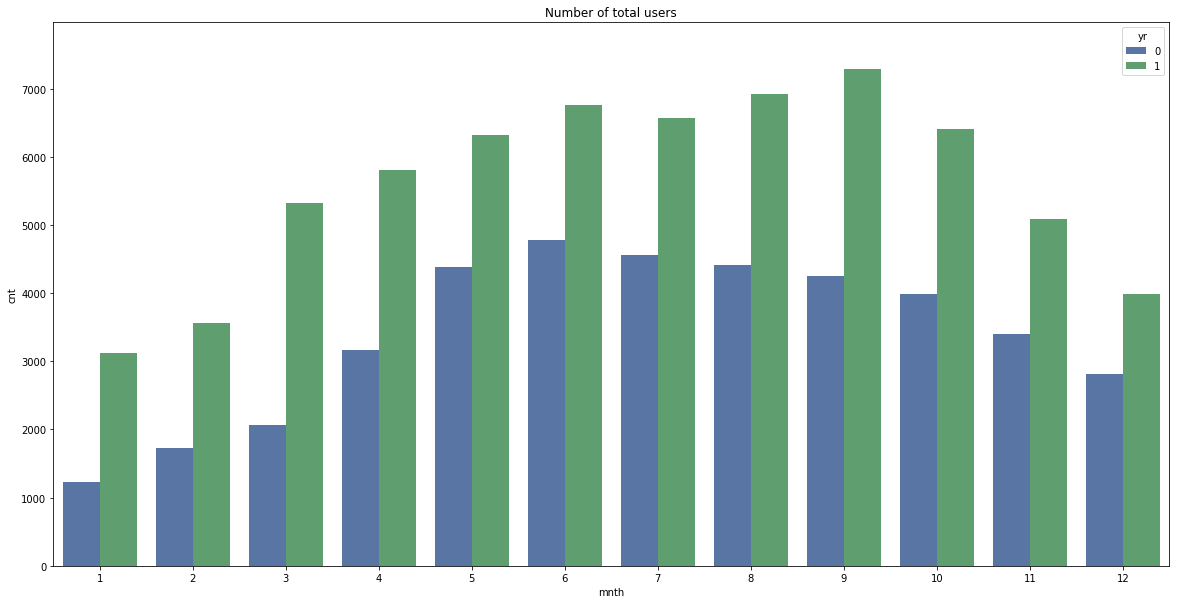

In [48]:
# Histogram Total Users by month
fig, ax = plt.subplots(figsize=(20, 10), sharex=False, sharey=True)

sns.barplot(data=dfday.compute(), x='mnth', y='cnt', hue = 'yr', errwidth=0, palette="deep")
ax.set(title="Number of total users")

[Text(0.5,1,'Number of total users')]

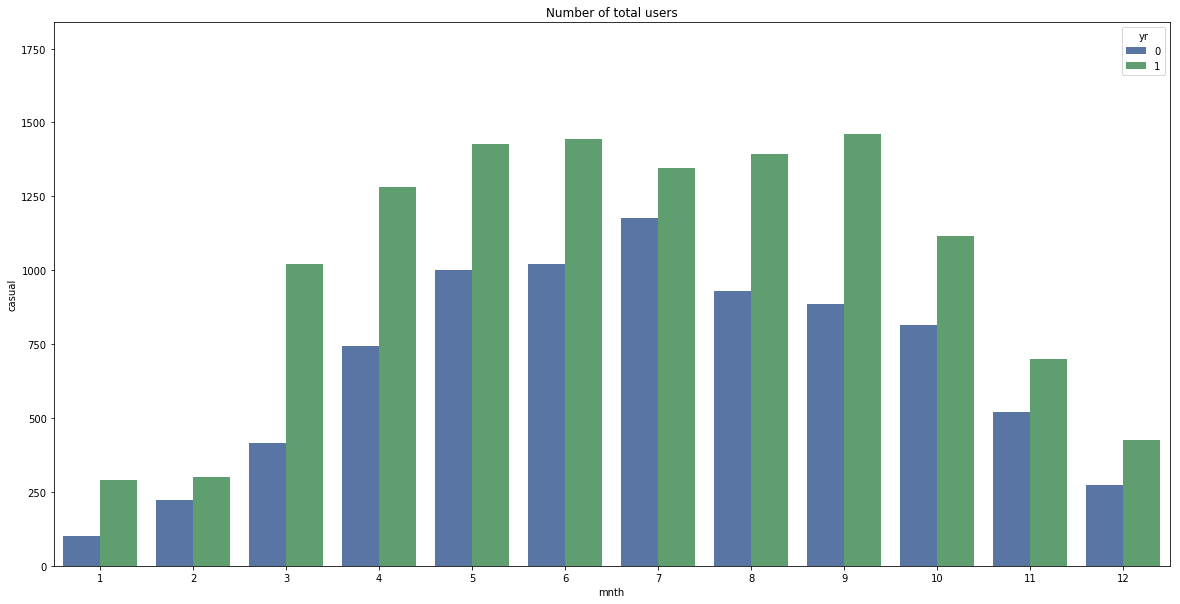

In [49]:
# Histogram Casual Users
fig, ax = plt.subplots(figsize=(20, 10), sharex=False, sharey=True)

sns.barplot(data=dfday.compute(), x='mnth', y='casual', hue = 'yr', errwidth=0, palette="deep")
ax.set(title="Number of total users")

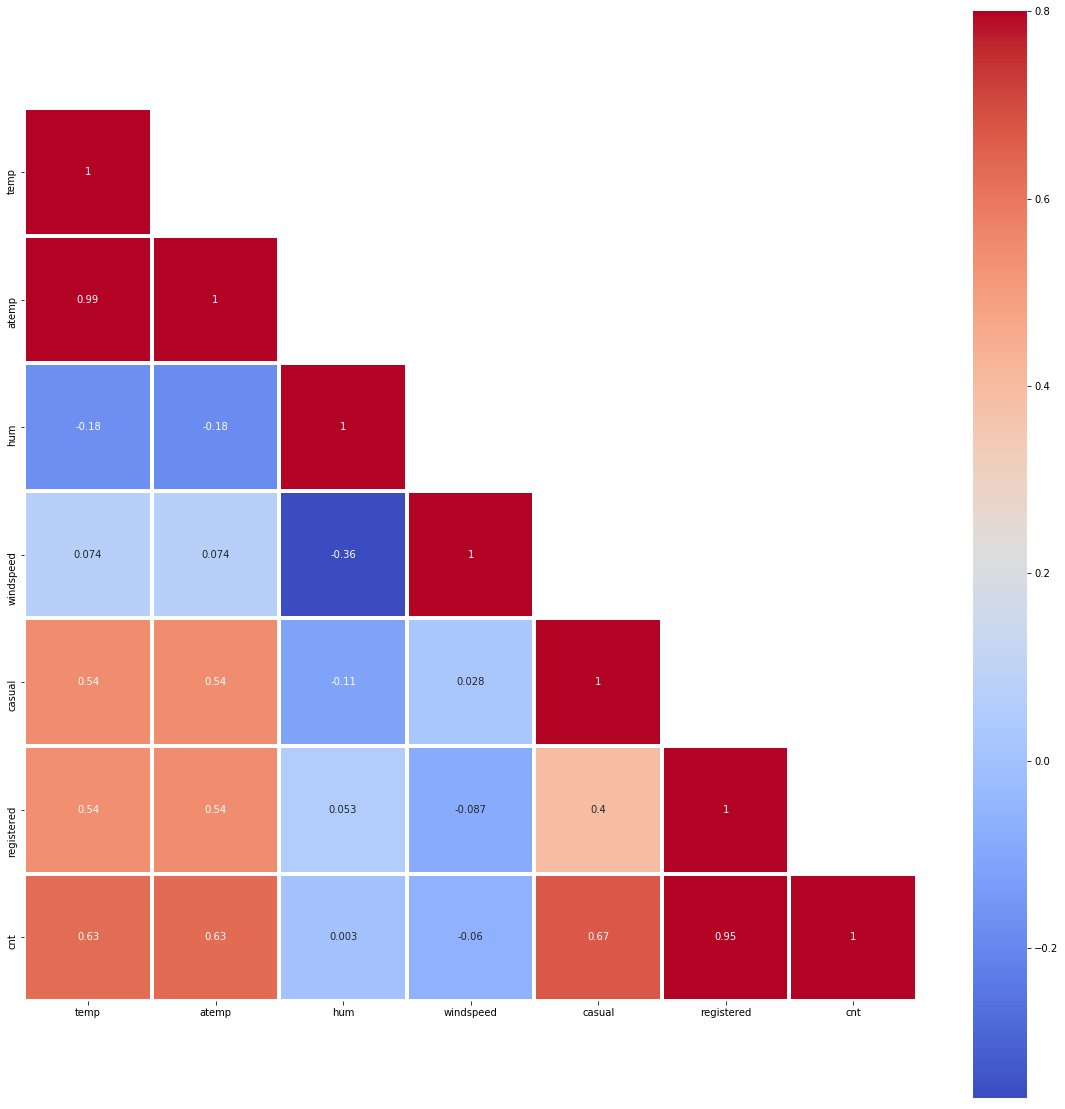

In [50]:
# create correlation matrix
corr_matrix = dfday.compute().corr()
# create a mask from correlation matrix
mask = np.array(corr_matrix)
# return the lower triangle of the matrix by setting the mask of the lower triangle to be false
mask[np.tril_indices_from(mask)] = False
fig,ax = plt.subplots(figsize=(20,20))
# plot correlation matrix to heatmap
sns.heatmap(corr_matrix,
            cmap='coolwarm',
            mask=mask,
            vmax=.8, 
            square=True,
            annot=True,
            linewidths=3,
            ax=ax)
plt.show(fig)

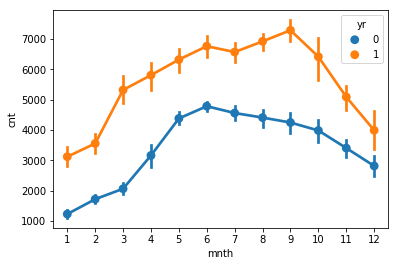

In [51]:
fig, ax = plt.subplots()
sns.pointplot(
    data=dfday[["mnth", "cnt", "yr"]].compute(),
    x="mnth",
    y="cnt",
    hue="yr",
    ax=ax,
)

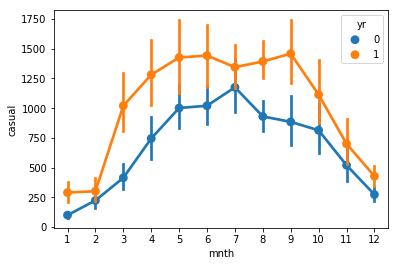

In [52]:
fig, ax = plt.subplots()
sns.pointplot(
    data=dfday[["mnth", "casual", "yr"]].compute(),
    x="mnth",
    y="casual",
    hue="yr",
    ax=ax,
)

## Divide into train and test

In [53]:
#Separate datasets in train and test
train = dfday.loc[0:638]
test = dfday.loc[639:730]

In [54]:
#Seting variables for modelling
train_y = train[['cnt']]
train_X = train.loc[:, train.columns].drop(['dteday','casual','registered','atemp','cnt'], axis = 1)
test_y = test[['cnt']]
test_X = test.loc[:, test.columns].drop(['dteday','casual','registered','atemp','cnt'], axis = 1)

## Modelling with Dask_ML

In [ ]:
from dask.distributed import Client
client = Client()

In [ ]:
#Creating a Linear Regression with Dask_ML
lr = LinearRegression(fit_intercept=False)
lr.fit(train_X, train_y)

In [ ]:
#Building the predictions and computing the r2_Score
test_y_pred = lr.predict(test_X.values)
r2_score(test_y.values.compute(), test_y_pred.compute())